In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import yaml

In [2]:
cx = 4
cy = 7
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((cx*cy,3), np.float32)
objp[:,:2] = np.mgrid[0:cx,0:cy].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('calib_drone_violet/*.jpg')
scs = 0
total = len(images)
checked = 0
for fname in images:
    print(fname)
    checked = checked + 1
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (cx,cy),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners = np.array([[corner for [corner] in corners]])
        scs = scs + 1
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (cx,cy), corners2,ret)
        
    print(fname, checked , '(', scs, ') /', total)    


calib_drone_orange/img_20230908_141259.jpg
calib_drone_orange/img_20230908_141259.jpg 1 ( 1 ) / 94
calib_drone_orange/img_20230908_141111.jpg
calib_drone_orange/img_20230908_141111.jpg 2 ( 2 ) / 94
calib_drone_orange/img_20230908_140945.jpg
calib_drone_orange/img_20230908_140945.jpg 3 ( 3 ) / 94
calib_drone_orange/img_20230908_141119.jpg
calib_drone_orange/img_20230908_141119.jpg 4 ( 4 ) / 94
calib_drone_orange/img_20230908_141303.jpg
calib_drone_orange/img_20230908_141303.jpg 5 ( 5 ) / 94
calib_drone_orange/img_20230908_140939.jpg
calib_drone_orange/img_20230908_140939.jpg 6 ( 6 ) / 94
calib_drone_orange/img_20230908_141307.jpg
calib_drone_orange/img_20230908_141307.jpg 7 ( 7 ) / 94
calib_drone_orange/img_20230908_141049.jpg
calib_drone_orange/img_20230908_141049.jpg 8 ( 8 ) / 94
calib_drone_orange/img_20230908_141213.jpg
calib_drone_orange/img_20230908_141213.jpg 9 ( 9 ) / 94
calib_drone_orange/img_20230908_141315.jpg
calib_drone_orange/img_20230908_141315.jpg 10 ( 9 ) / 94
calib_dro

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# transform the matrix and distortion coefficients to writable lists
data = {'camera_matrix': np.asarray(mtx).tolist(),
        'dist_coeff': np.asarray(dist).tolist()}

# and save it to a file
with open("violet_calibration_matrix.yaml", "w") as f:
    yaml.dump(data, f)

# done

In [4]:
with open("violet_calibration_matrix.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)
mtx = np.array(data_loaded['camera_matrix'])
dist = np.array(data_loaded['dist_coeff'])

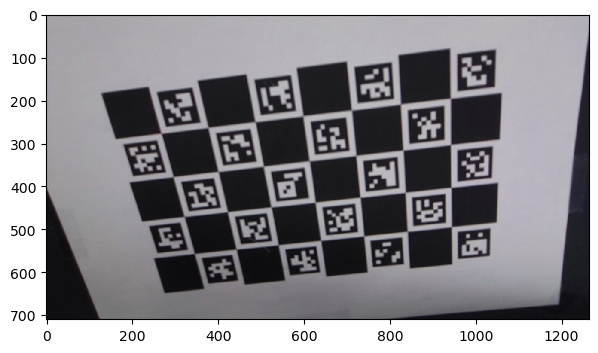

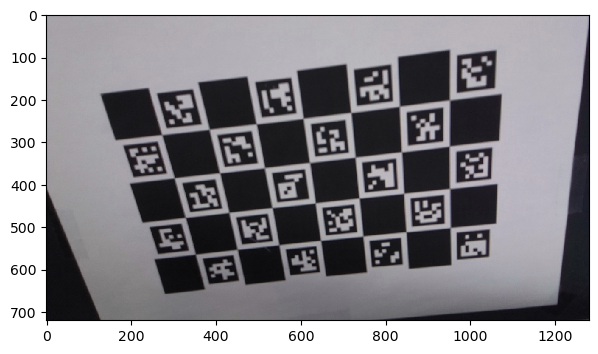

In [27]:
img = cv2.imread(np.random.choice(images))
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(7,7))
plt.imshow(dst)
plt.figure(figsize=(7,7))
plt.imshow(img)

In [6]:
newcameramtx

array([[1.01376126e+03, 0.00000000e+00, 6.36221870e+02],
       [0.00000000e+00, 1.01325568e+03, 3.51302399e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])